# Vote Distance & Financial Evolution Analysis

This notebook focuses on the analysis and modeling of congressional vote prediction.

### Focus Areas:
1. **Member Voting Similarity Matrix** - Vote distance/opposition patterns
2. **Within vs Between Party Similarities** - Party cohesion analysis
3. **Financial Evolution by Party** - Individual vs PAC vs Party trends over time  
4. **Most Opposed Member Pairs** - Coalition/opposition analysis

### Prediction Value:
- **Similarity matrices** for collaborative filtering approaches
- **Opposition scores** for adversarial voting prediction
- **Financial trend features** for temporal modeling
- **Party cohesion metrics** for swing member identification


In [4]:
import sys
sys.path.append("../..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

# Import data loading function
import importlib
try:
    import src.data_loaders.rollcall
    importlib.reload(src.data_loaders.rollcall)
    from src.data_loaders.rollcall import get_individual_votes_with_party_enriched_lobby
    print("Setup complete")
except Exception as e:
    print(f"Import error: {e}")
    from src.data_loaders.rollcall import get_individual_votes_with_party_enriched_lobby


Setup complete


In [13]:
print("Loading voting and financial data...")
df_full = get_individual_votes_with_party_enriched_lobby().reset_index()

print(f"Complete dataset: {df_full.shape}")
print(f"Time span: Congress {df_full['congress'].min()} - {df_full['congress'].max()}")
print(f"Unique members: {df_full['icpsr'].nunique():,}")

members_df = pd.read_csv('../data/house_senate_members.csv')
member_names = members_df[['icpsr', 'bioname', 'state_abbrev', 'party_code']].drop_duplicates('icpsr')

# Focus on recent congresses with good financial data
df_recent = df_full[df_full['congress'] >= 115].copy()
df_recent = df_recent.dropna(subset=['personal_cfscore', 'contributor_cfscore'])

print(f"Recent data (Congress 115+): {len(df_recent):,} records")
print(f"Recent members: {df_recent['icpsr'].nunique():,}")
print(f"Recent congresses: {sorted(df_recent['congress'].unique())}")

# Create member lookup
member_lookup = df_recent.groupby('icpsr').agg({
    'd': 'first', 'r': 'first', 
    'personal_cfscore': 'first', 'contributor_cfscore': 'first'
}).reset_index()

member_lookup = member_lookup.merge(member_names, on='icpsr', how='left')
member_lookup['party_label'] = member_lookup.apply(
    lambda x: 'Democrat' if x['d'] == 1 else ('Republican' if x['r'] == 1 else 'Independent'), axis=1
)

print(f"Member lookup created: {len(member_lookup)} members")


Loading voting and financial data...
Complete dataset: (2823025, 121)
Time span: Congress 101 - 115
Unique members: 1,623
Recent data (Congress 115+): 103,922 records
Recent members: 543
Recent congresses: [115]
Member lookup created: 543 members


In [11]:
print("Calculating member voting similarities...")

# Create voting matrix (members x votes) for the recent congress
vote_data = df_recent.copy()

# Create pivot table of votes
vote_matrix = vote_data.pivot_table(
    index='icpsr', 
    columns=['congress', 'chamber', 'rollnumber'], 
    values='vote_for',
    fill_value=-1  # -1 for abstention/missing votes
)

print(f"Vote matrix shape: {vote_matrix.shape}")
print(f"Members: {len(vote_matrix)}, Votes: {vote_matrix.shape[1]}")

# Filter members with sufficient voting records
min_votes = 50
vote_counts = (vote_matrix != -1).sum(axis=1)  # Count non-missing votes
active_members_mask = vote_counts >= min_votes
vote_matrix_active = vote_matrix[active_members_mask]

print(f"Active members with ≥{min_votes} votes: {len(vote_matrix_active)}")

# Sample subset for computational efficiency (limit to manageable size)
n_sample = min(100, len(vote_matrix_active))
if len(vote_matrix_active) > n_sample:
    sampled_members = vote_matrix_active.sample(n_sample, random_state=42)
    print(f"Sampled {n_sample} members for analysis")
else:
    sampled_members = vote_matrix_active
    print(f"Using all {len(sampled_members)} active members")

# Calculate pairwise correlations (similarities)
print("Calculating pairwise correlations...")
similarities = sampled_members.T.corr().values

# Calculate distances (1 - similarities) 
distances = 1 - similarities
np.fill_diagonal(distances, 0)  # Distance from self is 0

print(f"Similarity matrix shape: {similarities.shape}")
print(f"Similarity range: [{similarities.min():.3f}, {similarities.max():.3f}]")

# Get member information for sampled members
active_member_info = member_lookup[
    member_lookup['icpsr'].isin(sampled_members.index)
].reset_index(drop=True)

print(f"Active member info shape: {active_member_info.shape}")

# Display sample of the data
print("\nSample of active members:")
print(active_member_info[['icpsr', 'bioname', 'party_label', 'personal_cfscore']].head())


Calculating member voting similarities...
Vote matrix shape: (543, 266)
Members: 543, Votes: 266
Active members with ≥50 votes: 434
Sampled 100 members for analysis
Calculating pairwise correlations...
Similarity matrix shape: (100, 100)
Similarity range: [-0.170, 1.000]
Active member info shape: (100, 9)

Sample of active members:
     icpsr                     bioname party_label  personal_cfscore
0  10713.0          CONYERS, John, Jr.    Democrat            -0.707
1  15033.0        LEVIN, Sander Martin    Democrat            -0.688
2  15444.0  SLAUGHTER, Louise McIntosh    Democrat            -0.772
3  15446.0    UPTON, Frederick Stephen  Republican             0.877
4  15454.0         PALLONE, Frank, Jr.    Democrat            -0.404


Creating member voting similarity matrix...


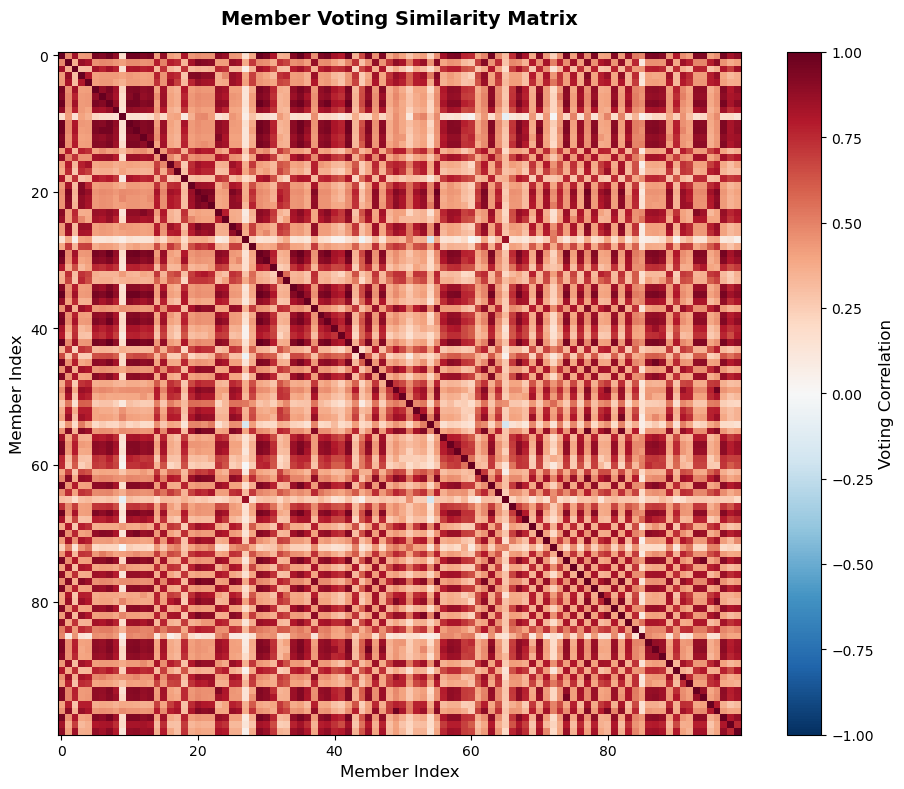

Similarity matrix: (100, 100)
Average similarity: 0.552
Similarity range: [-0.170, 1.000]


In [14]:
# Visualization 8: Member Voting Similarity Matrix
print("Creating member voting similarity matrix...")

plt.figure(figsize=(10, 8))
im = plt.imshow(similarities, cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Member Voting Similarity Matrix', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Member Index', fontsize=12)
plt.ylabel('Member Index', fontsize=12)
cbar = plt.colorbar(im)
cbar.set_label('Voting Correlation', fontsize=12)
plt.tight_layout()
plt.show()

# Statistical insights
upper_triangle = similarities[np.triu_indices_from(similarities, k=1)]
print(f"Similarity matrix: {similarities.shape}")
print(f"Average similarity: {upper_triangle.mean():.3f}")
print(f"Similarity range: [{similarities.min():.3f}, {similarities.max():.3f}]")


Creating party cohesion analysis:

 Party distribution in aligned sample:
Republican    54
Democrat      46
dtype: int64

Similarity by party type:
             count      mean       std       min       25%       50%  \
same_party                                                             
False       2484.0  0.358795  0.092499 -0.170272  0.318038  0.378929   
True        2466.0  0.746104  0.164516 -0.158483  0.690071  0.784943   

                 75%       max  
same_party                      
False       0.423845  0.854364  
True        0.864343  1.000000  


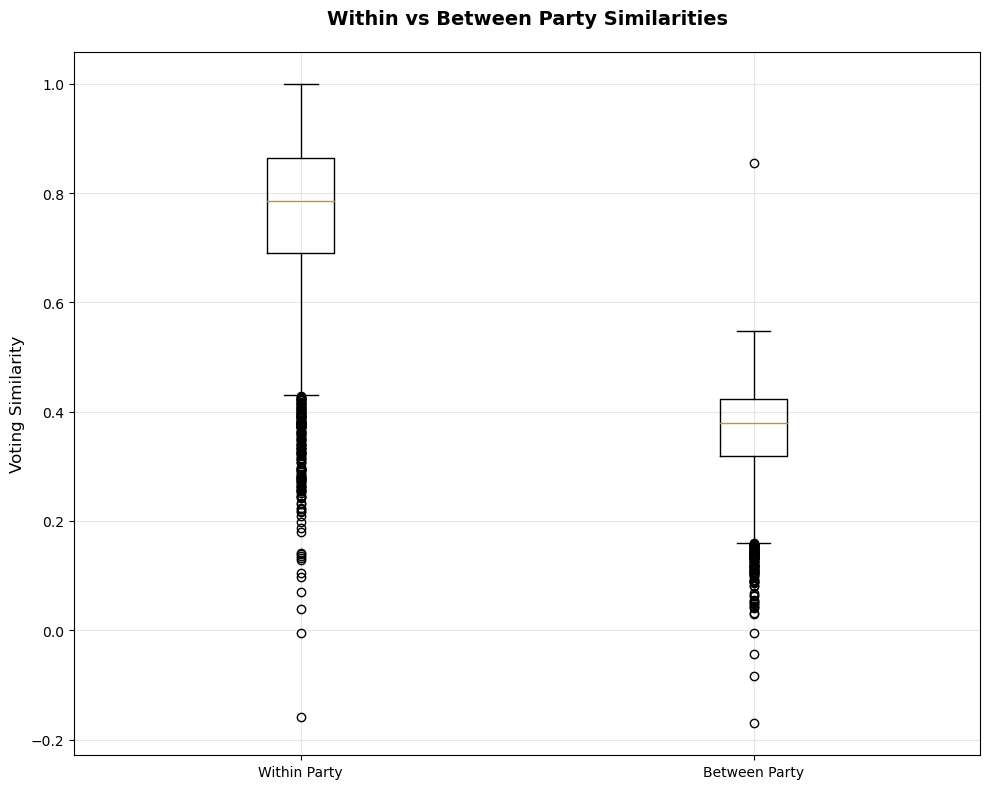


 Within-party average similarity: 0.746
Between-party average similarity: 0.359
Party polarization score: 0.387
Party pairs analyzed: 4,950


In [15]:
# Visualization 9: Within vs Between Party Similarities  
print("Creating party cohesion analysis:")


# Create a properly aligned party mapping using the exact same order as the similarity matrix
sampled_icpsr_order = sampled_members.index.tolist()  # This is the order used in similarity matrix

# Create aligned party information
party_info_aligned = []
for icpsr in sampled_icpsr_order:
    member_info = member_lookup[member_lookup['icpsr'] == icpsr]
    if len(member_info) > 0:
        party_info_aligned.append(member_info.iloc[0]['party_label'])
    else:
        party_info_aligned.append('Unknown')

print(f"\n Party distribution in aligned sample:")
party_counts = pd.Series(party_info_aligned).value_counts()
print(party_counts)

# Calculate party similarities with proper alignment
party_similarities = []
for i in range(len(party_info_aligned)):
    for j in range(i+1, len(party_info_aligned)):
        party_i = party_info_aligned[i]
        party_j = party_info_aligned[j]
        same_party = party_i == party_j
        similarity = similarities[i, j]
        
        party_similarities.append({
            'member_i_party': party_i,
            'member_j_party': party_j,
            'same_party': same_party,
            'similarity': similarity,
            'pair_type': f"{party_i} - {party_j}" if not same_party else party_i
        })

party_sim_df = pd.DataFrame(party_similarities)


print(f"\nSimilarity by party type:")
print(party_sim_df.groupby('same_party')['similarity'].describe())

within_party = party_sim_df[party_sim_df['same_party']]['similarity']
between_party = party_sim_df[~party_sim_df['same_party']]['similarity']

plt.figure(figsize=(10, 8))
plt.boxplot([within_party, between_party], labels=['Within Party', 'Between Party'])
plt.ylabel('Voting Similarity', fontsize=12)
plt.title('Within vs Between Party Similarities', fontsize=14, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Statistical insights
print(f"\n Within-party average similarity: {within_party.mean():.3f}")
print(f"Between-party average similarity: {between_party.mean():.3f}")
print(f"Party polarization score: {within_party.mean() - between_party.mean():.3f}")
print(f"Party pairs analyzed: {len(party_sim_df):,}")


Creating financial evolution analysis...

 Available financial columns: ['num_contributions', 'ind_contributions', 'pac_contributions', 'party_contributions']

Financial data spans Congress: [110, 111, 112, 113, 114, 115]
Members with financial data: 981

Party trends data points: 18
Sample of party trends:
   congress  party_label  individual_pct    pac_pct  party_pct
0       110     Democrat       55.223516  44.343857   0.432627
1       110  Independent       98.868913   1.112932   0.018155
2       110   Republican       57.613421  41.817136   0.569443
3       111     Democrat       56.195818  43.367881   0.436301
4       111  Independent       98.868913   1.112932   0.018155

Party representation: {'Democrat': 6, 'Independent': 6, 'Republican': 6}


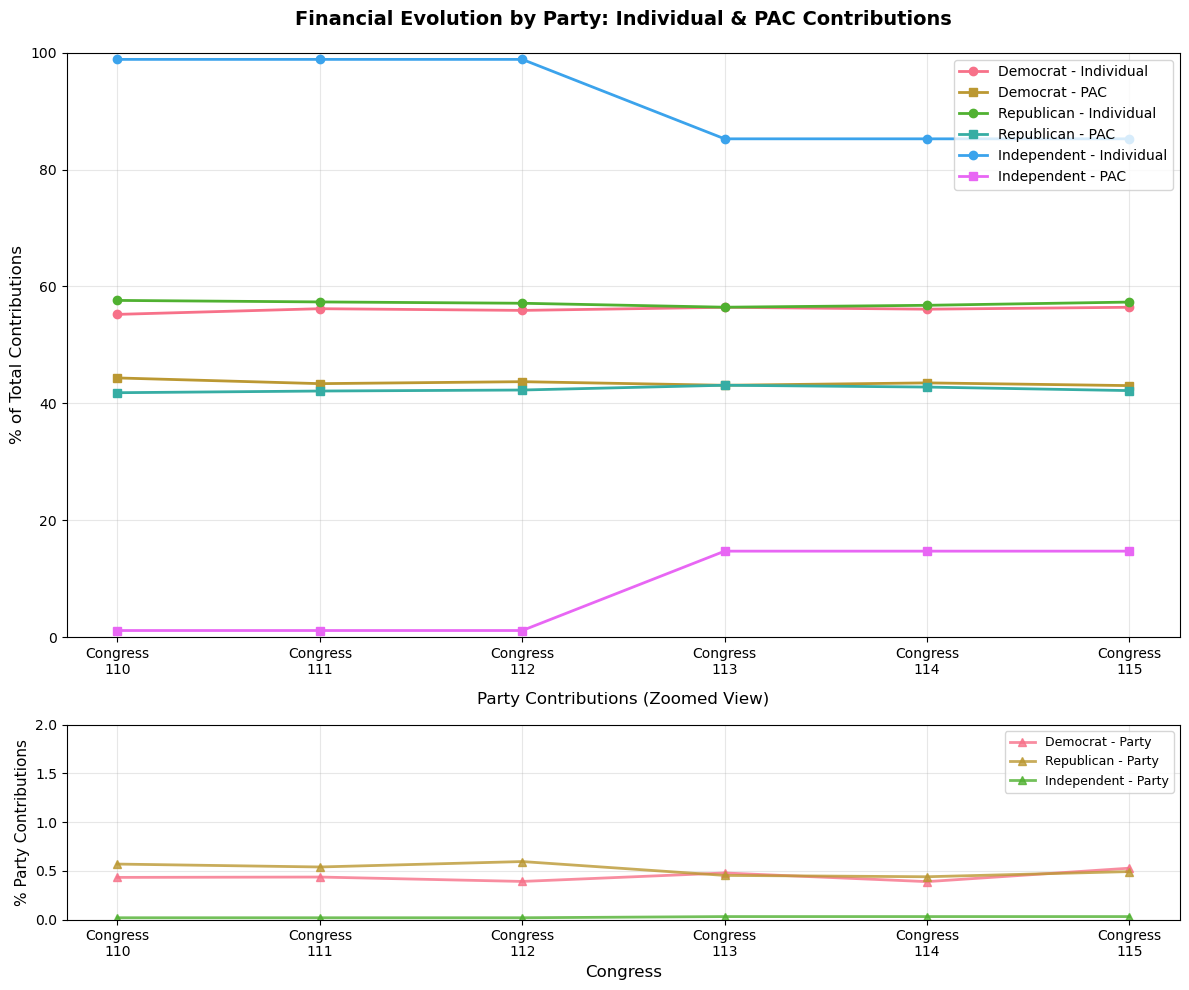

Financial trends analyzed: 3290 member-congress records
Congresses analyzed: [110, 111, 112, 113, 114, 115]
Average individual contributions: 56.7%
Average PAC contributions: 42.9%
Average party contributions: 0.5%


In [16]:
# Visualization 10: Financial Evolution by Party
print("Creating financial evolution analysis...")


# use Congress 110+ to get multiple data points for trends
df_financial_evolution = df_full[df_full['congress'] >= 110].copy()

# Check what financial columns are available
financial_cols = [col for col in df_financial_evolution.columns if 'contribution' in col.lower()]
print(f"\n Available financial columns: {financial_cols}")

# Prepare financial data using multiple Congress sessions
financial_trends = df_financial_evolution.groupby(['congress', 'icpsr']).agg({
    'pac_contributions': 'first',
    'ind_contributions': 'first', 
    'party_contributions': 'first',
    'd': 'first',
    'r': 'first'
}).reset_index()

# Calculate total contributions and percentages
financial_trends['total_contributions'] = (
    financial_trends['pac_contributions'].fillna(0) + 
    financial_trends['ind_contributions'].fillna(0) + 
    financial_trends['party_contributions'].fillna(0)
)

# Avoid division by zero
financial_trends = financial_trends[financial_trends['total_contributions'] > 0]

financial_trends['individual_pct'] = (financial_trends['ind_contributions'].fillna(0) / financial_trends['total_contributions']) * 100
financial_trends['pac_pct'] = (financial_trends['pac_contributions'].fillna(0) / financial_trends['total_contributions']) * 100
financial_trends['party_pct'] = (financial_trends['party_contributions'].fillna(0) / financial_trends['total_contributions']) * 100

# Create party labels
financial_trends['party_label'] = financial_trends.apply(
    lambda x: 'Democrat' if x['d'] == 1 else ('Republican' if x['r'] == 1 else 'Independent'), axis=1
)

print(f"\nFinancial data spans Congress: {sorted(financial_trends['congress'].unique())}")
print(f"Members with financial data: {financial_trends['icpsr'].nunique()}")

# Calculate aggregated trends by party (this is the key aggregation!)
party_trends = financial_trends.groupby(['congress', 'party_label']).agg({
    'individual_pct': 'mean',
    'pac_pct': 'mean', 
    'party_pct': 'mean'
}).reset_index().sort_values('congress')

print(f"\nParty trends data points: {len(party_trends)}")
print("Sample of party trends:")
print(party_trends.head())

# Check party distribution
party_counts = party_trends['party_label'].value_counts()
print(f"\nParty representation: {dict(party_counts)}")

# Dual subplot to handle low party contribution values
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [3, 1]})

# Main plot: Individual and PAC contributions (larger scale)
for party in ['Democrat', 'Republican', 'Independent']:
    party_data = party_trends[party_trends['party_label'] == party].sort_values('congress')
    if len(party_data) > 0:
        congress_vals = party_data['congress']
        ax1.plot(congress_vals, party_data['individual_pct'], 'o-', 
                label=f'{party} - Individual', linewidth=2, markersize=6)
        ax1.plot(congress_vals, party_data['pac_pct'], 's-', 
                label=f'{party} - PAC', linewidth=2, markersize=6)

ax1.set_title('Financial Evolution by Party: Individual & PAC Contributions', 
              fontsize=14, fontweight='bold', pad=20)
ax1.set_ylabel('% of Total Contributions', fontsize=12)
ax1.legend(fontsize=10, loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 100)

# Secondary plot: Party contributions (zoomed in to show detail)
for party in ['Democrat', 'Republican', 'Independent']:
    party_data = party_trends[party_trends['party_label'] == party].sort_values('congress')
    if len(party_data) > 0:
        congress_vals = party_data['congress']
        ax2.plot(congress_vals, party_data['party_pct'], '^-', 
                label=f'{party} - Party', linewidth=2, markersize=6, alpha=0.8)

ax2.set_title('Party Contributions (Zoomed View)', fontsize=12, pad=15)
ax2.set_xlabel('Congress', fontsize=12)
ax2.set_ylabel('% Party Contributions', fontsize=11)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, max(2, party_trends['party_pct'].max() * 1.2))  # Auto-scale or minimum 2%

# Improve x-axis formatting for both subplots
for ax in [ax1, ax2]:
    ax.set_xticks(sorted(party_trends['congress'].unique()))
    ax.set_xticklabels([f"Congress\n{int(c)}" for c in sorted(party_trends['congress'].unique())], 
                      fontsize=10)

plt.tight_layout()
plt.show()

# Statistical insights
print(f"Financial trends analyzed: {len(financial_trends)} member-congress records")
print(f"Congresses analyzed: {sorted(financial_trends['congress'].unique())}")
print(f"Average individual contributions: {financial_trends['individual_pct'].mean():.1f}%")
print(f"Average PAC contributions: {financial_trends['pac_pct'].mean():.1f}%")
print(f"Average party contributions: {financial_trends['party_pct'].mean():.1f}%")


Creating opposition pairs analysis...


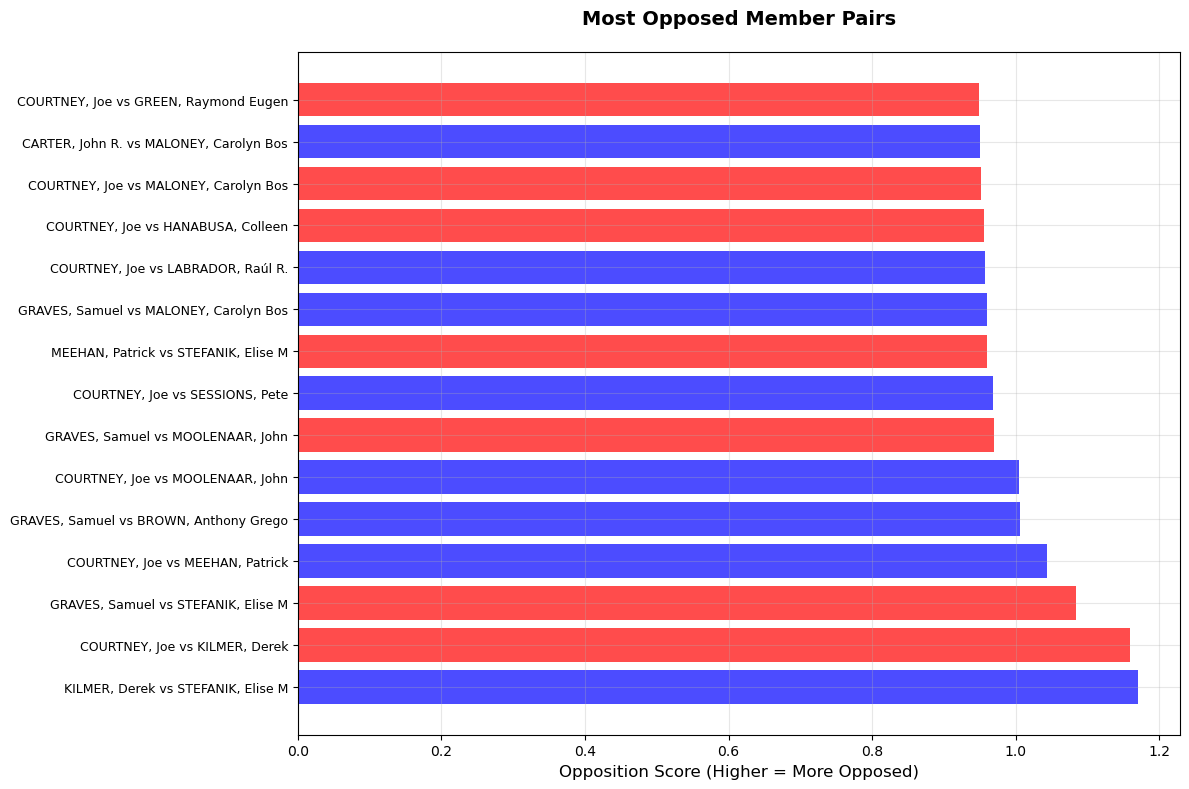

Member pairs analyzed: 4,950
Cross-party opposition pairs: 8/15
Same-party opposition pairs: 7/15
Top 5 most opposed pairs:
   • KILMER, Derek vs STEFANIK, Elise M - 1.170 (Democrat vs Republican)
   • COURTNEY, Joe vs KILMER, Derek - 1.158 (Same party!)
   • GRAVES, Samuel vs STEFANIK, Elise M - 1.084 (Same party!)
   • COURTNEY, Joe vs MEEHAN, Patrick - 1.044 (Democrat vs Republican)
   • GRAVES, Samuel vs BROWN, Anthony Grego - 1.006 (Republican vs Democrat)


In [17]:
# Visualization 11: Most Opposed Member Pairs
print("Creating opposition pairs analysis...")

# Calculate most opposed pairs
n_pairs = len(active_member_info)
most_opposed = []

for i in range(n_pairs):
    for j in range(i+1, n_pairs):
        member1 = active_member_info.iloc[i]
        member2 = active_member_info.iloc[j]
        opposition_score = distances[i, j]
        
        most_opposed.append({
            'member1': member1['bioname'][:20] if pd.notna(member1['bioname']) else f"Member {member1['icpsr']}",
            'member2': member2['bioname'][:20] if pd.notna(member2['bioname']) else f"Member {member2['icpsr']}",
            'party1': member1['party_label'],
            'party2': member2['party_label'],
            'opposition_score': opposition_score,
            'same_party': member1['party_label'] == member2['party_label']
        })

opposition_df = pd.DataFrame(most_opposed)
top_opposed = opposition_df.nlargest(15, 'opposition_score')

# Plot top opposition pairs
plt.figure(figsize=(12, 8))
y_pos = range(len(top_opposed))
colors = ['red' if same else 'blue' for same in top_opposed['same_party']]

plt.barh(y_pos, top_opposed['opposition_score'], color=colors, alpha=0.7)
plt.yticks(y_pos, [f"{row['member1']} vs {row['member2']}" 
                   for _, row in top_opposed.iterrows()], fontsize=9)
plt.xlabel('Opposition Score (Higher = More Opposed)', fontsize=12)
plt.title('Most Opposed Member Pairs', fontsize=14, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Statistical insights
print(f"Member pairs analyzed: {len(opposition_df):,}")
print(f"Cross-party opposition pairs: {(~top_opposed['same_party']).sum()}/{len(top_opposed)}")
print(f"Same-party opposition pairs: {top_opposed['same_party'].sum()}/{len(top_opposed)}")
print("Top 5 most opposed pairs:")
for _, row in top_opposed.head(5).iterrows():
    party_note = "(Same party!)" if row['same_party'] else f"({row['party1']} vs {row['party2']})"
    print(f"   • {row['member1']} vs {row['member2']} - {row['opposition_score']:.3f} {party_note}")


In [2]:
print("\n Features for vote prediction modeling:")
print("• Similarity matrices for collaborative filtering")
print("• Opposition scores for adversarial prediction")  
print("• Financial trend features for temporal modeling")
print("• Party cohesion metrics for swing member identification")


 Features for vote prediction modeling:
• Similarity matrices for collaborative filtering
• Opposition scores for adversarial prediction
• Financial trend features for temporal modeling
• Party cohesion metrics for swing member identification
